<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/multi_material-CT_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
#
#  Copyright 2025 United Kingdom Research and Innovation
#  Copyright 2025 Bangor University
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC) & Iwan Mitchell (Bangor University)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1)

# Single-material example: reproducing the CT scan of a teapot

One might say we like tea in the UK, which is true. However, we acquired the data in France with the [Dual Tube High Energy (DTHE) device](https://www.rx-solutions.com/en/blog/126/dthe-technology) by [RX Solutions](https://www.rx-solutions.com/) installed at the [MATEIS Laboratory](https://mateis.insa-lyon.fr/en) of [INSA-Lyon](http://www.insa-lyon.fr/). The DTHE is a double tomograph designed around one rotation axis and two 300 kV X-ray beamlines. 

We'll aim to reproduce one scan we made. We'll input all the experimental parameters in the simulation. 
For that purpose, we'll use our JSON format. 
It'll makes it so much easier than typing all the Python code. 
Describe the simulation and there you go.


<!-- Up to now, we generated 2D radiographs. 
This time we are going to simulate the computed tomography (CT) acquisition of a section of electric cable. 
A cone-beam geometry is used. 
To keep it simple, we consider an ideal case: no scintillation, no point-spread function (PSF), and a monochromatic spectrum. -->

<!-- We will use CIL to reconstruct the CT data with the traditional FDK algorithm. -->

<!-- ![Volume rendering of the CT data](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/multi_material-CT_scan/k3d_screenshot-volume_rendering.png?raw=1) -->

<div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the required packages.
</div>

## Aims of this session

<!-- 1. Understand the notion of pixel size in the context of a cone-beam geometry and how the magnification affects it.
2. Use OpenSCAD to generate a section of electric cable and save the geometries in STL files.
3. Combine two models made of two different types of material, one chemical element (copper), one a compound (PVC).
4. Simulate an ideal cone-beam computed tomography (CBCT) scan acquisition based on an actual experiment performed with the [Dual Tube High Energy (DTHE) device](https://doi.org/10.1016/j.tmater.2024.100030) by [RX Solutions](https://www.rx-solutions.com/) at [INSA Lyon](https://www.insa-lyon.fr/).
5. Demonstrate how to reconstruct the corresponding CT volume with the [Core Imaging Library (CIL)](https://github.com/TomographicImaging/CIL).
6. Save the reconstructed slices as a TIFF stack using 16-bit unsigned integers.
7. Explore the reconstructed volume and illustrate the partial view artefacts due to the partial view effect on the first and last slices.
8. Use [K3D Jupyter](https://github.com/K3D-tools/K3D-jupyter) to interactively visualise the data with volume rendering.

![Screenshot of the 3D environment using K3D](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/multi_material-CT_scan/k3d_screenshot-cropped.png?raw=1) -->

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    !conda install -y -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.2.0 ipp=2021.12 astra-toolbox=*=cuda* tigre k3d

    !apt-get install -y openscad
    !pip install gvxr viewscad

    import os, urllib.request

    # if not os.path.exists("../data/Wire-Cu-2mm-17.54umvx"):
    #     os.makedirs("../data/Wire-Cu-2mm-17.54umvx");

    # files = ["../data/Wire-Cu-2mm-17.54umvx/img_00000.tif",
    #         "notebooks/gvxr2json.py",
    #         ];

    # url = "https://github.com/TomographicImaging/gVXR-Tutorials/raw/refs/heads/main/../data/Wire-Cu-2mm-17.54umvx/img_00000.tif";
    # print("Download", url)
    # urllib.request.urlretrieve(url, "../data/Wire-Cu-2mm-17.54umvx/img_00000.tif");

    # url = "https://github.com/TomographicImaging/gVXR-Tutorials/raw/refs/heads/main/../data/Wire-Cu-2mm-17.54umvx/unireconstruction.xml";
    # print("Download", url)
    # urllib.request.urlretrieve(url, "../data/Wire-Cu-2mm-17.54umvx/unireconstruction.xml");

    
    url = "https://github.com/TomographicImaging/gVXR-Tutorials/raw/refs/heads/main/notebooks/gvxr2json.py";
    print("Download", url)
    urllib.request.urlretrieve(url, "gvxr2json.py");

## Summary of the ~~simulation~~ experimental parameters

| Parameters | Values | Units | Function call |
|------------|--------|-------|---------------|
| Source to object distance | 400.88 | mm | `gvxr.setSourcePosition(...)` |
| Source type (beam shape) | Point source (cone beam) | | `gvxr.usePointSource()` |
| Tube voltage | 260 | kV |  |
| Tube current | 300 | uA |  |
| Source to detector distance | 858.354 | mm | `gvxr.setDetectorPosition(...)` |
| Detector orientation | [0, 0, 1] |  | `gvxr.setDetectorUpVector(...)` |
| Detector resolution | 2872 &times; 2872 | pixels | `gvxr.setDetectorNumberOfPixels(...)` |
| Pixel pitch | 150 &times; 150 | um | `gvxr.setDetectorPixelSize(...)` |

## Import packages

- `pandas`
- `xml.etree`

<!-- - `os` to create the output directory if needed
- `matplotlib` to show 2D images
- `viewscad` to use OpenSCAD and create STL files
- `base64` to use save a screenshot of the K3D visualisation
- `tifffile.imread` to read the X-ray projection of the real experiment
- `xml.etree.ElementTree` to read the scanning parameters of the real experiment
- `gvxrPython3.gvxr` to simulate X-ray images
- `gvxrPython3.visualise` to use K3D to visualise the 3D environment
- `gvxrPython3.gvxr2json` to save the state of the simulation in JSON file
- `gvxrPython3.JSON2gVXRDataReader` to read the simulated data and prepare it for CIL
- `cil.recon.FDK` to reconstruct the CT volume using the FDK algorithm (3D-CBCT only) 
- `cil.recon.FBP` to reconstruct the CT volume using the FBP algorithm (2D/3D parallel geometry only) 
- `cil.io.TIFFWriter` to save the reconstructed slices as a TIFF stack
- `cil.processors.TransmissionAbsorptionConverter` to normalise the data and apply the minus log
- `cil.utilities.display.show_geometry` to display the acquisition geometry
- `cil.utilities.display.show2D` to show static 2D images
- `cil.utilities.jupyter.islicer` to show and navigate a stack of 2D images using a slider
- `cil.utilities.jupyter.link_islicer` to compare and navigate stacks of 2D images using a slider -->

In [12]:
import os # Create the output directory if necessary
import numpy as np # Who does not use Numpy?

# import math

import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting

font = {'family' : 'serif',
         'size'   : 15
       }
matplotlib.rc('font', **font)

# # Uncomment the line below to use LaTeX fonts
# # matplotlib.rc('text', usetex=True)

# import viewscad # Use OpenSCAD to create STL files

# import base64

# from tifffile import imread

# import xml.etree.ElementTree as ET

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

# import pandas
from xml.etree import ElementTree
# from gvxrPython3.utils import visualise

# # Use temporary bug fix
# if os.path.exists("gvxr2json.py"):
#     print("Use temporary bug fix")
#     import gvxr2json
# #Use the file provided by gVXR's package
# else:
#     print("Use the file provided by gVXR's package")
#     from gvxrPython3 import gvxr2json

# from gvxrPython3.JSON2gVXRDataReader import *

# from cil.recon import FDK # For CBCT
# from cil.recon import FBP # For parallel beam geometry

# from cil.io import TIFFWriter

# from cil.processors import TransmissionAbsorptionConverter
# from cil.utilities.display import show_geometry, show2D
# from cil.utilities.jupyter import islicer, link_islicer

# import k3d

# from ipywidgets import interact

## 1. Reading the important information from metadata files

There are three files of interest, one is a spreadsheet; the other two XML files:

- [../data/theiere-Fe-10mm/geom.csv](../data/theiere-Fe-10mm/geom.csv),
- [../data/theiere-Fe-10mm/unireconstruction.xml](../data/theiere-Fe-10mm/unireconstruction.xml).
- [../data/theiere-Fe-10mm/restore.macro](../data/theiere-Fe-10mm/restore.macro).

We'll use Numpy to read the spreadsheet, and xml.etree for the other files.

In [23]:
# Constant values not available in the metadata
exposures = [0.067, 0.083, 0.111, 0.167, 0.333, 0.500] # [s]
imager_pixel_spacing_in_um = np.array([150, 150])
filtration = [["Fe", 10, "mm"]]

geom_fname = "../data/theiere-Fe-10mm/geom.csv"
unireconstruction_fname = "../data/theiere-Fe-10mm/unireconstruction.xml"
restore_fname = "../data/theiere-Fe-10mm/restore.macro"

1st, the spreadsheet

In [17]:
data = np.loadtxt(geom_fname, 
    delimiter=';',
    skiprows=2,
    usecols=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
);

new_columns = [
    "source - x",
    "source - y",
    "source - z",
    "Imager Center - x",
    "Imager Center - y",
    "Imager Center - z",
    "Imager Top - x",
    "Imager Top - y",
    "Imager Top - z",
    "Imager Right - x",
    "Imager Right - y",
    "Imager Right - z"
];

# Get the number of projections
N_slices = data.shape[0];

# Get the source position
source_position_x = data[:,0]
source_position_y = data[:,1]
source_position_z = data[:,2]

# Get the detector centre
detector_centre_x = data[:,3]
detector_centre_y = data[:,4]
detector_centre_z = data[:,5]

# Get the detector top
detector_top_x = data[:,6]
detector_top_y = data[:,7]
detector_top_z = data[:,8]

# Get the detector right
detector_right_x = data[:,9]
detector_right_y = data[:,10]
detector_right_z = data[:,11]

# Compute the rotation angles
angles = np.linspace(0, 360, N_slices, False);

print("Number of projections:", N_slices)


Number of projections: 1504


Plot the data.

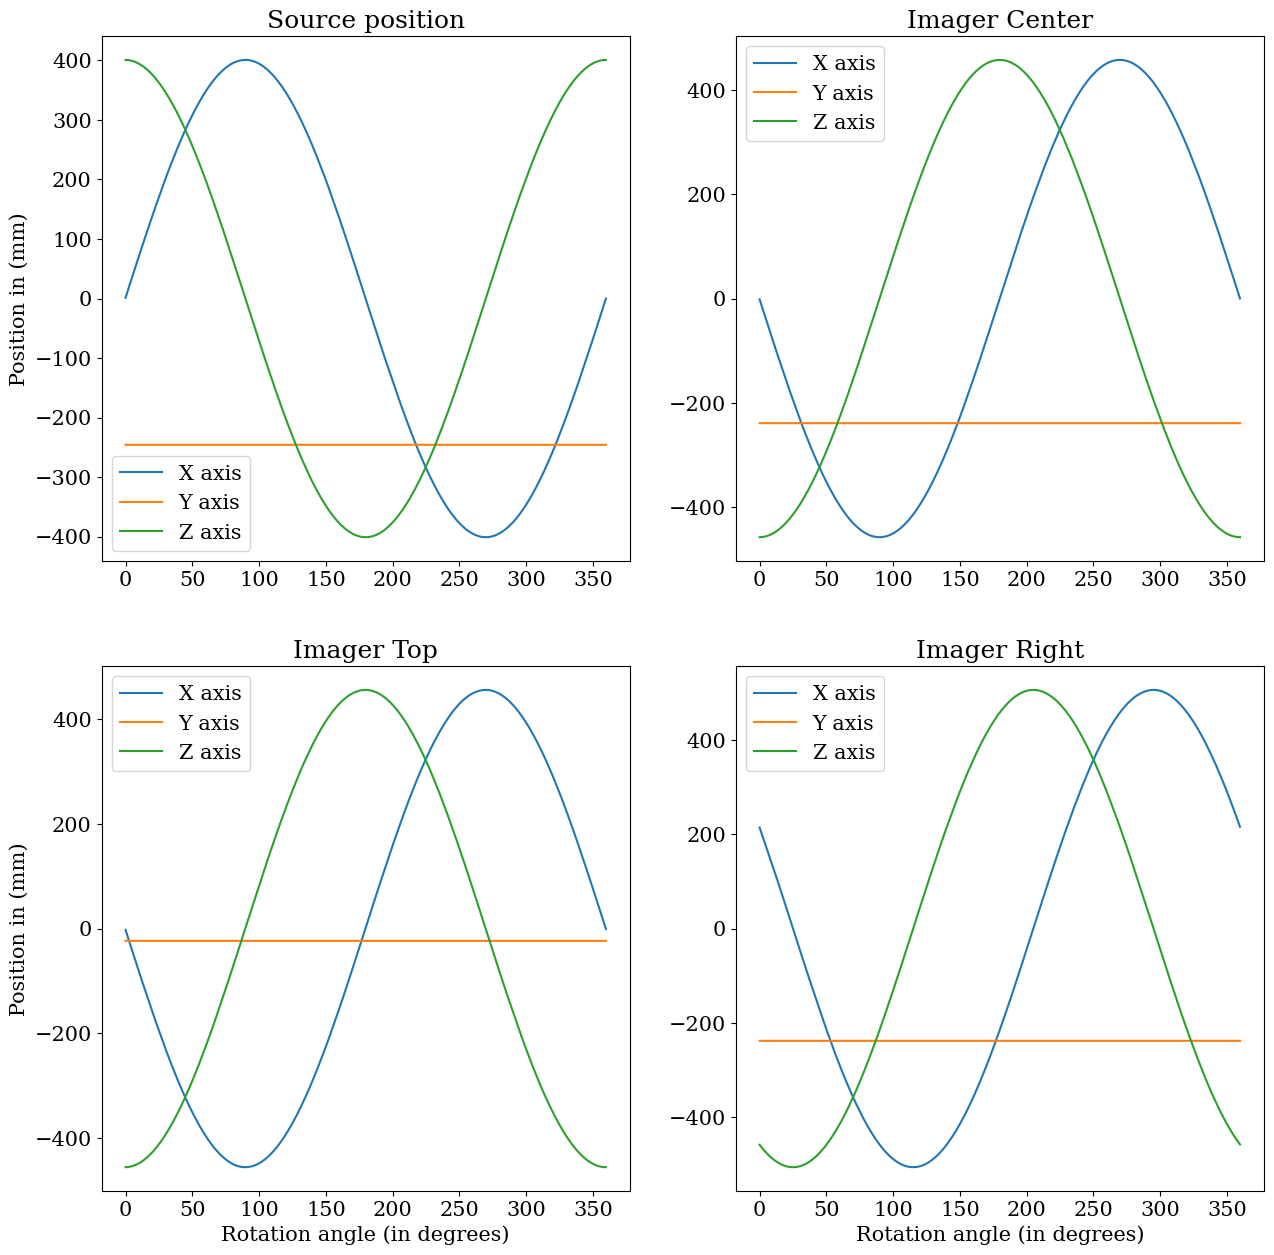

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15,15));

i = 0; j = 0;
axs[j,i].set_title("Source position");
axs[j,i].plot(angles, source_position_x, label="X axis");
axs[j,i].plot(angles, source_position_y, label="Y axis");
axs[j,i].plot(angles, source_position_z, label="Z axis");
axs[j,i].legend();
# axs[j,i].set_xlabel("Rotation angle (in degrees)");
axs[j,i].set_ylabel("Position in (mm)");

i = 1; j = 0;
axs[j,i].set_title("Imager Center");
axs[j,i].plot(angles, detector_centre_x, label="X axis");
axs[j,i].plot(angles, detector_centre_y, label="Y axis");
axs[j,i].plot(angles, detector_centre_z, label="Z axis");
axs[j,i].legend();
# axs[j,i].set_xlabel("Rotation angle (in degrees)");
# axs[j,i].set_ylabel("Position in (mm)");

i = 0; j = 1;
axs[j,i].set_title("Imager Top");
axs[j,i].plot(angles, detector_top_x, label="X axis");
axs[j,i].plot(angles, detector_top_y, label="Y axis");
axs[j,i].plot(angles, detector_top_z, label="Z axis");
axs[j,i].legend();
axs[j,i].set_xlabel("Rotation angle (in degrees)");
axs[j,i].set_ylabel("Position in (mm)");

i = 1; j = 1;
axs[j,i].set_title("Imager Right");
axs[j,i].plot(angles, detector_right_x, label="X axis");
axs[j,i].plot(angles, detector_right_y, label="Y axis");
axs[j,i].plot(angles, detector_right_z, label="Z axis");
axs[j,i].legend();
axs[j,i].set_xlabel("Rotation angle (in degrees)");
# axs[j,i].set_ylabel("Position in (mm)");

Then the first XML file

In [9]:
# Open the XML file
tree = ElementTree.parse(unireconstruction_fname)

# Find the conebeam profile
profile = tree.find("conebeam/profile")
assert profile is not None

# Get the number of projections
number_of_projections = int(profile.attrib["images"])
assert number_of_projections == N_slices

# Find the acquisition information
acquisition_info = tree.find("conebeam/acquisitioninfo")
assert acquisition_info is not None

# Find the acquisition geometry
conf_geo = acquisition_info.find("geometry")
assert conf_geo is not None

# Get the SDD and SOD
source_to_detector = float(conf_geo.attrib["sdd"])
source_to_object = float(conf_geo.attrib["sod"])
object_to_detector = source_to_detector - source_to_object


print("Profile:", profile)
print("Number of projections:", number_of_projections)

print("Source to detector distance (SDD):", source_to_detector, "mm")
print("Source to object distance (SOD):", source_to_object, "mm")
print("Object to detector distance (ODD):", object_to_detector, "mm")

Profile: <Element 'profile' at 0x7fb0edf7bce0>
Number of projections: 1504
Source to detector distance (SDD): 858.354 mm
Source to object distance (SOD): 400.88 mm
Object to detector distance (ODD): 457.47400000000005 mm


In [96]:
# Open the XML file
exposure_ID = None
tree = ElementTree.parse(restore_fname)
root = tree.getroot()
root.tag

# Find the gui
gui = root[0]
assert gui is not None
assert gui.tag == "gui"

# Find the imager
imager = gui.attrib["imager"]
assert imager == "Imager_1" or  imager == "Imager_2"

# Find the point
point = root[1]
assert point is not None
assert point.tag == "point"

# Find the imager that was used
for node in point:
    if node.attrib["name"] == imager:

        # Find the exposure
        for imager_property in node:
            if imager_property.attrib["name"] == "exposure":
                exposure_ID = int(imager_property.attrib["value"])

assert exposure_ID is not None

exposure_in_s = exposures[exposure_ID - 1]
print("Exposure:", exposure_in_s, "s")

Exposure: 0.5 s


Display the experimental image using the pixel size as the distance between two successive pixels on the detector.

In [ ]:
vmin=0.0;
vmax=1.0;

fig = plt.figure();
plt.imshow(raw_reference, cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(raw_reference.shape[1]-1)*imager_pixel_spacing_in_um[0]/1000.0,0,(raw_reference.shape[0]-1)*imager_pixel_spacing_in_um[1]/1000.0])
plt.title("Digital radiograph of section of electric cable from my garage")
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.colorbar()
plt.show()

Looking at the image above, it seems that the width of the electric cable section in a bit more than 100 mm, i.e. 10 cm, which is obviously wrong. To address this is, we can take into acount the magnification due to the cone-beam geometry to retrieve the pixel size on the object plane. This is the technique used in medical imaging to determine the size of anatomic structures from 2D digital radiographs (DRs).

Read the parameters from the experiment

In [ ]:
tree = ET.parse('../data/Wire-Cu-2mm-17.54umvx/unireconstruction.xml');
root = tree.getroot();

geometry_branch = root.findall('conebeam/acquisitioninfo/geometry')[0];
sod = float(geometry_branch.attrib["sod"]);
sdd = float(geometry_branch.attrib["sdd"]);

print("Source-Object Distance:", sod, "mm")
print("Source-Detector Distance:", sdd, "mm")

voxel_size_branch = root.findall('conebeam/volume_acquisition/voxelSize')[0];
voxel_size = [
    float(voxel_size_branch.attrib["X"]),
    float(voxel_size_branch.attrib["Y"]),
    float(voxel_size_branch.attrib["Z"])
];

size_branch = root.findall('conebeam/volume_acquisition/size')[0];
number_of_voxels = [
    int(size_branch.attrib["X"]),
    int(size_branch.attrib["Y"]),
    int(size_branch.attrib["Z"])
];

print("Voxel size:", voxel_size, "mm")
print("Number of voxels:", number_of_voxels)

Compute the magnification

$$magnification = \frac{SDD}{SOD}$$

with $SDD$ the source to detector distance and $SOD$ the source to object distance.

<div class="alert alert-block alert-warning">
    <b>Note:</b> To myself, add a diagram.
</div>

In [ ]:
magnification = sdd / sod;
print("Magnification:", magnification)

Compute the pixel size in the object plane

In [ ]:
spacing_in_mm = (imager_pixel_spacing_in_um / magnification) / 1000.0;
print("Pixel size:", spacing_in_mm, "mm");

Display the experimental image using the "pixel size" in the object plane rather than the detector plane.

In [ ]:
vmin=0.0;
vmax=1.0;

fig = plt.figure();
plt.imshow(raw_reference, cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(raw_reference.shape[1]-1)*spacing_in_mm[0],0,(raw_reference.shape[0]-1)*spacing_in_mm[1]])
plt.title("Digital radiograph of section of electric cable from my garage")
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.colorbar()
plt.show()

Now the width of my electric cable is about 10mm, i.e. 1cm, which is about right.

## 2. OpenSCAD to generate a section of electric cable

Where to save the data

In [ ]:
output_path = "output_data/multi_material-CT_scan"
if not os.path.exists(output_path):
    os.makedirs(output_path);

We describe the geometry with the OpenSCAD language.

In [ ]:
scad_function_string = """

height = 100;
twist = 0;

module wire_strand (height, twist)
{
    union()
    {
        linear_extrude(height = height, center = true, convexity = 10, twist = 0)
        translate([0, 0, 0])
        circle(r = 1, $fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([2, 0, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([-2, 0, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([-1, 1.72, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([1, 1.72, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([-1, -1.72, 0])
        circle(r = 1,$fn = 100);

        linear_extrude(height = height, center = true, convexity = 10, twist = twist)
        translate([1, -1.72, 0])
        circle(r = 1,$fn = 100);
    }
}

module wires (height, twist)
{
    union ()
    {
        // Ground wire
        linear_extrude(height = height, center = true, convexity = 10, twist = 0)
        translate([0, 0, 0])
        circle(r = 2, $fn = 100);

        // Twisted wires
        translate([8, 0, 0])
        wire_strand(height, twist);

        translate([-8, 0, 0])
        wire_strand(height, twist);
    }
}

""";

Each component must be save in a separate STL file.

In [ ]:
scad_wire_str = """
    wires (height + 20, twist);
""";

wire_fname_stl = os.path.join(output_path, "wires.stl");

if not os.path.exists(wire_fname_stl):
    r = viewscad.Renderer()
    r.render(scad_function_string + scad_wire_str, outfile=wire_fname_stl)

In [ ]:
scad_plastic_sheath_str = """
    difference()
    {
        linear_extrude(height = height+1, center = true, convexity = 10, twist = 0)
            translate([0, 0, 0])
            resize([30,10])circle(r=13, $fn= 100);
        wires (height, twist);
    }
""";

insulation_fname_stl = os.path.join(output_path, "insulation.stl");

if not os.path.exists(insulation_fname_stl):
    r = viewscad.Renderer()
    r.render(scad_function_string + scad_plastic_sheath_str, outfile=insulation_fname_stl)

## 3. Combining two models made of two different types of material

We use some of the parameters of an actual experiment performed with the [Dual Tube High Energy (DTHE) device](https://doi.org/10.1016/j.tmater.2024.100030) by [RX Solutions](https://www.rx-solutions.com/) at [INSA Lyon](https://www.insa-lyon.fr/). We start with the usual business, i.e. creating an OpenGL context, setting the parameters of the source and detector, and eventually load the new STL files.

In [ ]:
# Create an OpenGL context
gvxr.createOpenGLContext();

# We increase the size of the visualisation framebuffer to generate higher resolution screenshots. It does not affect the simulation.
gvxr.setWindowSize(1000, 1000)

In [ ]:
# Set the X-ray source position and shape
gvxr.setSourcePosition(0.0, sod, 0.0, "mm");
gvxr.usePointSource();

# Set the Spectrum
gvxr.setMonoChromatic(100, "keV", 16000); # 100 keV is about the average photon energy

In [ ]:
# Set the detector properties
scaling_factor = 4

gvxr.setDetectorPosition(0.0, -(sdd - sod), 0.0, "mm");
gvxr.setDetectorUpVector(0, 0, 1);
gvxr.setDetectorNumberOfPixels(raw_reference.shape[1] // scaling_factor, raw_reference.shape[0] // scaling_factor);
gvxr.setDetectorPixelSize(imager_pixel_spacing_in_um[0] * scaling_factor, imager_pixel_spacing_in_um[1] * scaling_factor, "um");

The section of electric cable combine two models. One is made of copper, the other one of PVC. In the case of the chemical element, the density of the material can be omitted. This is not the case for the compound. The composition of PVC is C2H3Cl and density is ~1.3 g/cm<sup>3</sup>.

In [ ]:
geometry_set = {
    "wires": {"fname": wire_fname_stl, "Element": "Cu", "Colour" : [0.722, 0.451, 0.20, 1.0]},
    "stealh": {"fname": insulation_fname_stl, "Compound": "C2H3Cl", "Density" : 1.3, "Colour" : [0.5, 0.5, 0.5, 1.0]},
}

translation_vector_in_mm = [0.0, -100.0, 0.0];

for label in geometry_set:
    gvxr.loadMeshFile(label, geometry_set[label]["fname"], "mm");

    # Chemical element
    if "Element" in geometry_set[label]:
        gvxr.setElement(label, geometry_set[label]["Element"]);
    # Compound + density
    elif "Compound" in geometry_set[label] and "Density" in geometry_set[label]:
        gvxr.setCompound(label, geometry_set[label]["Compound"]);
        gvxr.setDensity(label, geometry_set[label]["Density"], "g/cm3");
    # Mixture + density
    elif "Mixture" in geometry_set[label] and "Density" in geometry_set[label]:
        gvxr.setMixture(label, geometry_set[label]["Mixture"]);
        gvxr.setDensity(label, geometry_set[label]["Density"], "g/cm3");
    # Hounsfield unit
    elif "HU" in geometry_set[label]:
        gvxr.setHounsfieldUnit(label, round(geometry_set[label]["HU"]));
    # Unsupported
    else:
        raise ValueError("Unknow material composition for " + label + " in " + str(geometry_set[label]))

    # Colour in the 3D visualisation
    if "Colour" in geometry_set[label]:
        gvxr.setColour(label,
            geometry_set[label]["Colour"][0],
            geometry_set[label]["Colour"][1],
            geometry_set[label]["Colour"][2],
            geometry_set[label]["Colour"][3]);

    gvxr.translateNode(label, *translation_vector_in_mm, "mm");

We are now ready to compute an X-ray image and display it.

In [ ]:
x_ray_image = np.array(gvxr.computeXRayImage(), dtype=np.single) / gvxr.getTotalEnergyWithDetectorResponse();

We can display it side-by-side with the experimental image. The images will look different because:

- The material compositions we used in the simulation correspond to theorical values. They are likely to differ from the material used to manufacture the electric cable.
- The simulated source is monochromatic. This is not realistic.
- The simulated sample is a CAD model, not generated from the segmentation of the experimental CT volume, we'll see why later.

In [ ]:
vmin = 0.0;
vmax = 1.0;

# Plot the two images side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

im1 = axes.flat[0].imshow(raw_reference, cmap="gray", vmin=vmin, vmax=vmax,
    extent=[0,(raw_reference.shape[1]-1)*spacing_in_mm[0],0,(raw_reference.shape[0]-1)*spacing_in_mm[1]])
axes.flat[0].set_title("Ground truth")


im2 = axes.flat[1].imshow(x_ray_image, cmap="gray", vmin=vmin, vmax=vmax,
    extent=[0,(x_ray_image.shape[1]-1)*spacing_in_mm[0]*scaling_factor,0,(x_ray_image.shape[0]-1)*spacing_in_mm[1]*scaling_factor])
axes.flat[1].set_title("gVirtualXRay")

axes.flat[0].set_xlabel("Pixel position\n(in mm)")
axes.flat[1].set_xlabel("Pixel position\n(in mm)")
axes.flat[0].set_ylabel("Pixel position\n(in mm)")

cb_ax = fig.add_axes([0.925, 0.35, 0.02, 0.275])
cbar = fig.colorbar(im1, cax=cb_ax)
plt.show()

It may be useful to visualise the 3D environment to ascertain everything is as expected. It can be done in a window or offscreen with a screenshot.
We use both the functionality built in gVXR and K3D

We use k3D if possible. It's a nice 3D visualisation framework for Jupyter notebooks.

In [ ]:
if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

plot = visualise(use_log=True, use_negative=True, sharpen_ksize=2, sharpen_alpha=1.0);

if plot:
    plot.display();

In [ ]:
if plot:
    plot.fetch_screenshot();

In [ ]:
if plot:
    screenshot_fname = os.path.join(output_path, "k3d_screenshot.png");
    if not os.path.exists(screenshot_fname):
        k3d_screenshot = plot.screenshot;
        data = base64.b64decode(k3d_screenshot);
        with open(screenshot_fname, "wb") as fp:
            fp.write(data);
            fp.flush();
            fp.close();

if IN_COLAB:
    output.disable_custom_widget_manager()

## 4. Compute the X-ray projections for a CT acquisition

In [ ]:
number_of_projections = 200;

gvxr.computeCTAcquisition(os.path.join(output_path, "projections-" + str(number_of_projections)), # the path where the X-ray projections will be saved.
                                                                    # If the path is empty, the data will be stored in the main memory, but not saved on the disk.
                                                                    # If the path is provided, the data will be saved on the disk, and the main memory released.
                          os.path.join(output_path, "screenshots-" + str(number_of_projections)), # the path where the screenshots will be saved.
                                                                    # If kept empty, not screenshot will be saved.
                          number_of_projections, # The total number of projections to simulate.
                          0, # The rotation angle corresponding to the first projection.
                          True, # A boolean flag to include or exclude the last angle. It is used to calculate the angular step between successive projections.
                          360,
                          0, # The number of white images used to perform the flat-field correction. If zero, then no correction will be performed.
                          *translation_vector_in_mm, # The location of the rotation centre.
                          "mm", # The corresponding unit of length.
                          *gvxr.getDetectorUpVector(), # The rotation axis
                          True # If true the energy fluence is returned, otherwise the number of photons is returned
                               # (default value: true)
);

In [ ]:
# Save the current simulation states in a JSON file.
# It could be used to re-run the simulation, or to read the data with CIL.
json_fname = os.path.join(output_path, "simulation-" + str(number_of_projections) + ".json");
gvxr2json.saveJSON(json_fname);

## 5. Demonstrate how to reconstruct the corresponding CT volume with the [Core Imaging Library (CIL)](https://github.com/TomographicImaging/CIL).

In [ ]:
# Read the simulated data with CIL.
reader = JSON2gVXRDataReader(json_fname);
data = reader.read()

In [ ]:
print("data.geometry", data.geometry)

In [ ]:
show2D(data)

In [ ]:
islicer(data)

In [ ]:
data_corr = TransmissionAbsorptionConverter(white_level=data.max())(data)

In [ ]:
show2D(data_corr)

In [ ]:
islicer(data_corr)

In [ ]:
data_corr.reorder(order='tigre')

In [ ]:
ig = data_corr.geometry.get_ImageGeometry();

print("Image geometry", ig)

In [ ]:
# Perform the reconstruction with CIL
FDK_reconstruction = FDK(data_corr, ig).run()

In [ ]:
# Look at partial view artefacts
show2D(FDK_reconstruction, slice_list=[1, FDK_reconstruction.shape[0] // 2, FDK_reconstruction.shape[0] - 2], title=["2nd slice", "Middle slice", "Slice before last"], num_cols=3)

## 6. Save the reconstructed slices as a TIFF stack using 16-bit unsigned integers.


In [ ]:
# Save the reconstructed CT images
writer = TIFFWriter(data=FDK_reconstruction, file_name=os.path.join(output_path, "recons-" + str(number_of_projections), "slice_"), compression="uint16");
writer.write();

## 7. Explore the reconstructed volume and illustrate the partial view artefacts due to the partial view effect on the first and last slices.

In [ ]:
islicer(FDK_reconstruction, minmax=None)

## 8. Volume rendering with [K3D Jupyter](https://github.com/K3D-tools/K3D-jupyter)

First, we compute the volume bound to make sure the voxel size is taken into account. This is particularly important if the voxel size is not isotropic.

In [ ]:
bounds = [
    ig.center_x - ig.voxel_num_x / 2.0 * ig.voxel_size_x,
    ig.center_x + ig.voxel_num_x / 2.0 * ig.voxel_size_x,

    ig.center_y - ig.voxel_num_y / 2.0 * ig.voxel_size_y,
    ig.center_y + ig.voxel_num_y / 2.0 * ig.voxel_size_y,

    ig.center_z - ig.voxel_num_z / 2.0 * ig.voxel_size_z,
    ig.center_z + ig.voxel_num_z / 2.0 * ig.voxel_size_z
]

We retrieve the Numpy array from the CIL volume, and create a k3D volume.

In [ ]:
CT_volume = k3d.volume(FDK_reconstruction.as_array().astype(np.single), 
                       color_map=np.array(k3d.basic_color_maps.Jet, dtype=np.float32),
                       bounds=bounds, 
)

Visualise the CT data using volume rendering.

---
## Task:

- Run the cell below,
- In the control panel on the right-hand side, adjust the values in the tab `Objects->Volume #1`.

In [ ]:
if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

plot = k3d.plot()
plot += CT_volume
plot.display()

It is possible to control the visualisation from the code directly.

---
## Task:

- Run the cell below,
- Adjust the sliders:
    - to show air with transparency, and
    - to reveal the electric cable.

In [ ]:
min_value = FDK_reconstruction.min()
max_value = FDK_reconstruction.max()

def update(vmin=min_value, vmax=max_value):
    CT_volume.color_range = [min(vmin, vmax), max(vmin, vmax)]

interact(update, vmin=(min_value, max_value), vmax=(min_value, max_value));

# Further work

We can clearly see streak artefacts in the reconstructed volume. This is because the number of projections is too low. It is called "Aliasing Artefacts" in the occurence. You can read about it in [Chapter 5 on "Aliasing Artifacts and Noise in CT Images"](https://doi.org/10.1137/1.9780898719277.ch5) of the famous book entitled ["Principles of Computerized Tomographic Imaging"](https://doi.org/10.1137/1.9780898719277) by Avinash C. Kak and Malcolm Slaney. See https://engineering.purdue.edu/~malcolm/pct/ for details.

As a rule of thumb, the number of projections should be at least:
$$
\frac{\pi}{2} \times ncols
$$

with $ncols$ the number of pixels of the detector along the x-axis. In our case, it is equal to `gxvr.getDetectorNumberOfPixels()[0]`

---
## Task:

- Identify the size of the detector using `gxvr.getDetectorNumberOfPixels()[0]` in the cell below,
- Use the formula provided above to calculate the number of projections we should have used in theory,
- Compare this value with 200, the default number of projections we use in this notebook, it was far too low indeed,
- Increase the number of projections in the call of `gvxr.computeCTAcquisition(...)`, and
- Re-run the notebook.

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [ ]:
gvxr.terminate();